In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"utsavmodi2811","key":"ae46a780b6c396bf1fc4c66c7608e020"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ismailpromus/skin-diseases-image-dataset
!unzip skin-diseases-image-dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-65.jpg  
  inflating: dataset/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-66.jpg  
  inflating: dataset/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-67.jpg  
  inflating: dataset/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-69.jpg  
  inflating: dataset/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-7.jpg  
  inflating: dataset/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-70.jpg  
  inflating: dataset/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-71.jpg  
  inflating: dataset/IMG_CLASSES/7. Psoriasis pictures

In [3]:
!pip install split-folders

In [19]:
import splitfolders
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow.keras.backend as K

In [5]:
import splitfolders

# Path to the source folder where your disease class folders are stored
input_folder = "/content/dataset/IMG_CLASSES"  # Path to the 'IMG_CLASSES' directory

# Output path for the split data
output_folder = "/content/dataset/base_dir"  # Path where train/val split will be saved

# Split the dataset into train (80%) and validation (20%)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2))


Copying files: 27153 files [01:19, 343.61 files/s] 


In [6]:
train_dir = '/content/dataset/base_dir/train'
val_dir = '/content/dataset/base_dir/val'

In [22]:
import tensorflow as tf
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K

class FocalLoss(Loss):
    def __init__(self, gamma=2., alpha=0.25, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = self.alpha * K.pow(1 - y_pred, self.gamma) * cross_entropy
        return K.sum(loss, axis=1)


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 21719 images belonging to 10 classes.
Found 5434 images belonging to 10 classes.


In [13]:
# STEP 8: Class Weights + Optional Oversampling (Extra Effective)
from collections import Counter
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler

labels = train_generator.classes
class_weights_array = class_weight.compute_class_weight(class_weight='balanced',
                                                        classes=np.unique(labels),
                                                        y=labels)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.6196122296793438), 1: np.float64(1.2912604042806184), 2: np.float64(0.8646098726114649), 3: np.float64(2.161094527363184), 4: np.float64(0.8171181339352896), 5: np.float64(0.34063676286072775), 6: np.float64(1.306013229104029), 7: np.float64(1.3211070559610705), 8: np.float64(1.4704807041299932), 9: np.float64(1.5958119030124909)}


In [23]:
# STEP 9: Model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [24]:
model.compile(optimizer=Adam(1e-4), loss=FocalLoss(), metrics=['accuracy'])

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 944s 1s/step - accuracy: 0.5282 - loss: 0.2368 - val_accuracy: 0.7181 - val_loss: 0.1027
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 805s 1s/step - accuracy: 0.7542 - loss: 0.1117 - val_accuracy: 0.7889 - val_loss: 0.0793
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 824s 1s/step - accuracy: 0.8115 - loss: 0.0804 - val_accuracy: 0.7819 - val_loss: 0.0772
Epoch 4/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 803s 1s/step - accuracy: 0.8437 - loss: 0.0624 - val_accuracy: 0.8130 - val_loss: 0.0728
Epoch 5/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 789s 1s/step - accuracy: 0.8737 - loss: 0.0455 - val_accuracy: 0.8070 - val_loss: 0.0782
Epoch 6/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 792s 1s/step - accuracy: 0.8941 - loss: 0.0354 - val_accuracy: 0.8276 - val_loss: 0.0749
Epoch 7/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 808s 1s/step - accuracy: 0.9073 - loss: 0.0309 - val_accuracy: 0.8123 - val_loss: 0.0844
Epoch 8/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 788s 1s/step - accuracy: 0.9268 - loss: 0.0233 - val_accu

In [27]:
# Save the trained model
model.save("skin_disease_model.h5")

# Download the file
from google.colab import files
files.download("skin_disease_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

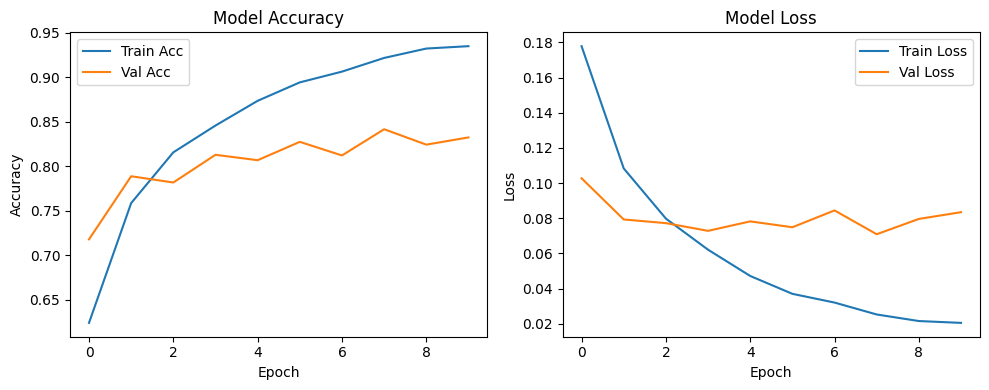

In [28]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


170/170 ━━━━━━━━━━━━━━━━━━━━ 59s 319ms/step


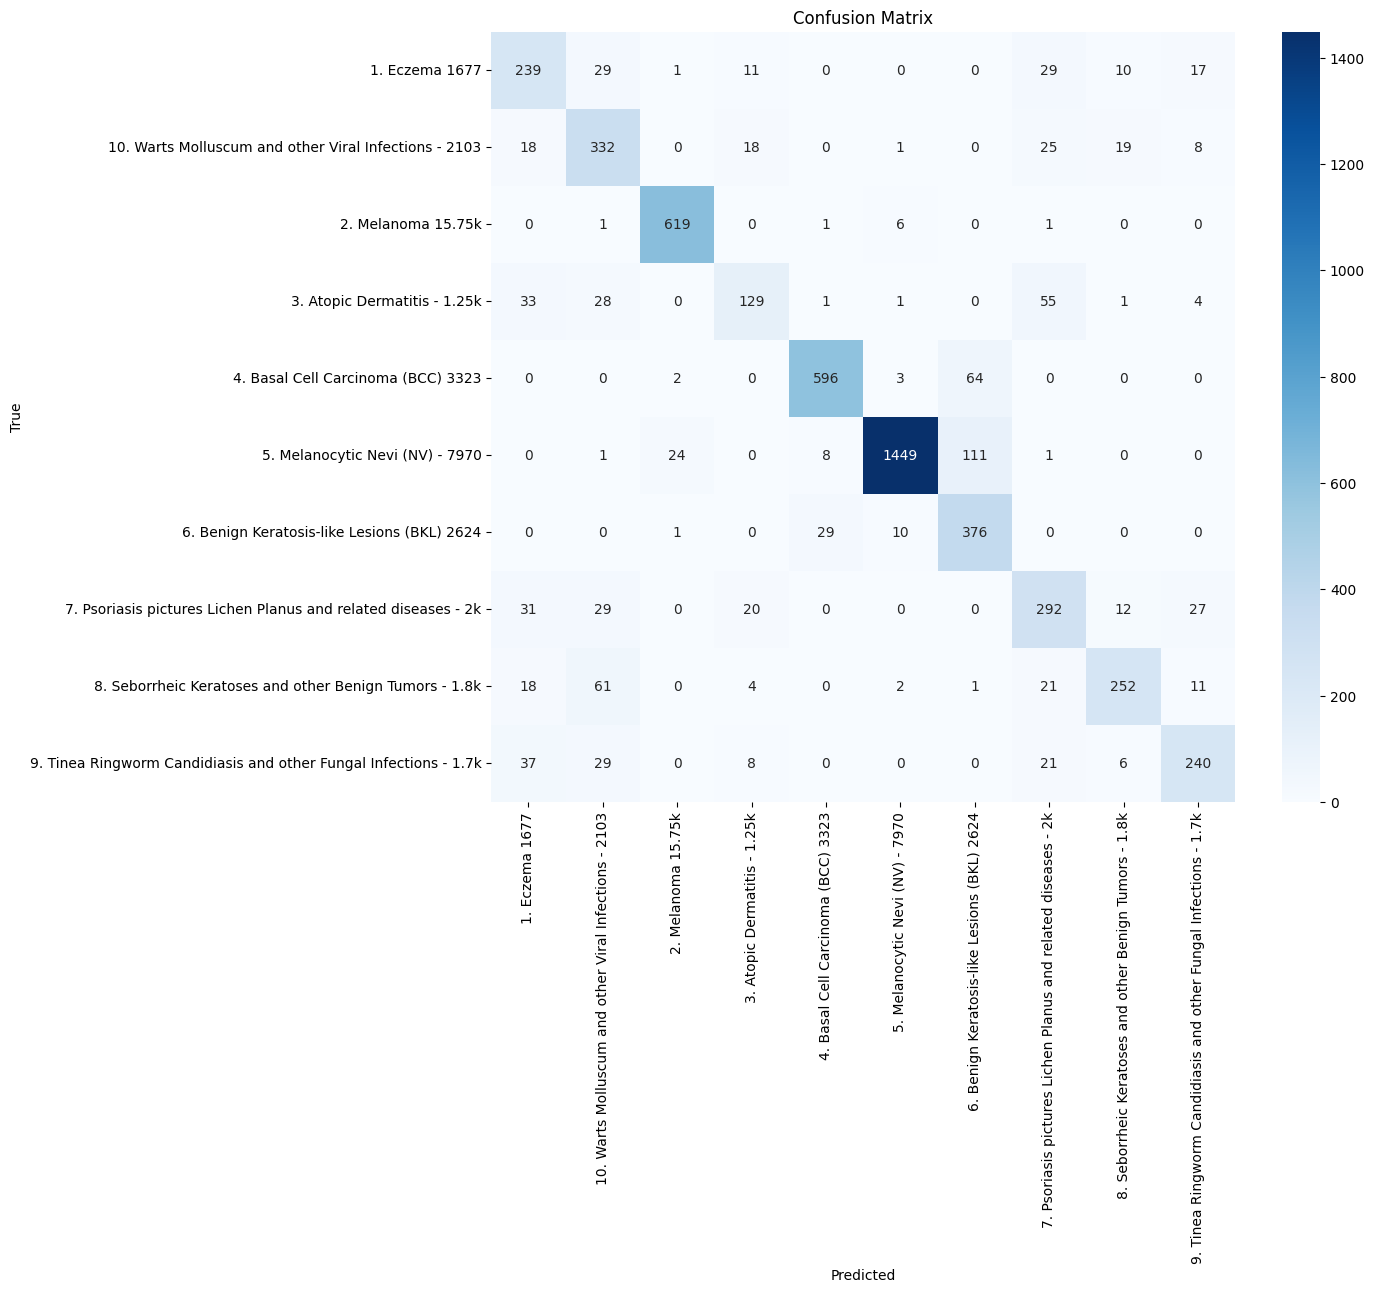

Classification Report:
                                                                   precision    recall  f1-score   support

                                                  1. Eczema 1677       0.64      0.71      0.67       336
           10. Warts Molluscum and other Viral Infections - 2103       0.65      0.79      0.71       421
                                              2. Melanoma 15.75k       0.96      0.99      0.97       628
                                    3. Atopic Dermatitis - 1.25k       0.68      0.51      0.58       252
                              4. Basal Cell Carcinoma (BCC) 3323       0.94      0.90      0.92       665
                                 5. Melanocytic Nevi (NV) - 7970       0.98      0.91      0.95      1594
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.68      0.90      0.78       416
   7. Psoriasis pictures Lichen Planus and related diseases - 2k       0.66      0.71      0.68       411
          8. Seborrhe

In [29]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# Predict
val_generator.reset()
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


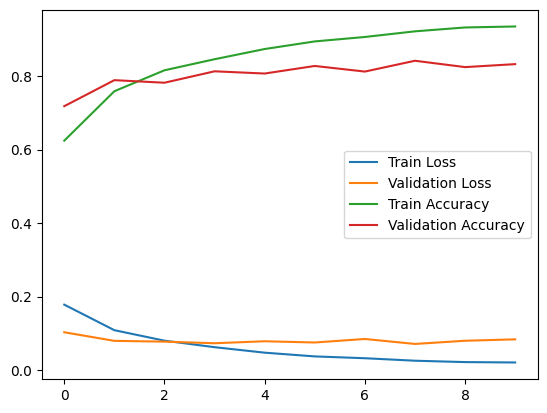

In [30]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.savefig('training_history.png')

In [31]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_24[0][0]    

 Total params: 68,800,664 (262.45 MB)

 Trainable params: 22,915,378 (87.42 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 45,830,758 (174.83 MB)

In [41]:
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files

# Upload the file
uploaded = files.upload()

# Get the first uploaded image filename
img_path = list(uploaded.keys())[0]

# Load and preprocess the image
img = image.load_img(img_path, target_size=(299, 299))  # Xception input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale

# Predict using the loaded model
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
class_labels = list(train_generator.class_indices.keys())

print(f"Predicted class: {class_labels[predicted_class]}")
print("Class probabilities:")
for i, prob in enumerate(prediction[0]):
    print(f"{class_labels[i]}: {prob:.4f}")


Saving ISIC_0025767.jpg to ISIC_0025767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class: 6. Benign Keratosis-like Lesions (BKL) 2624
Class probabilities:
1. Eczema 1677: 0.0000
10. Warts Molluscum and other Viral Infections - 2103: 0.0000
2. Melanoma 15.75k: 0.0001
3. Atopic Dermatitis - 1.25k: 0.0000
4. Basal Cell Carcinoma (BCC) 3323: 0.0010
5. Melanocytic Nevi (NV) - 7970: 0.1044
6. Benign Keratosis-like Lesions (BKL) 2624: 0.8943
7. Psoriasis pictures Lichen Planus and related diseases - 2k: 0.0000
8. Seborrheic Keratoses and other Benign Tumors - 1.8k: 0.0001
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k: 0.0000


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import pickle

# Load the trained model
model = load_model("/content/skin_disease_model.h5")

# Load class labels (you must have saved this earlier during training)
with open('/content/class_labels.pkl', 'rb') as f:
    class_labels = pickle.load(f)

# Upload the file
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Load and preprocess the image
img = image.load_img(img_path, target_size=(299, 299))  # For Xception
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Predict
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Output results
print(f"\n Predicted class: {class_labels[predicted_class]}")
print("\n Class probabilities:")
for i, prob in enumerate(prediction[0]):
    print(f"{class_labels[i]}: {prob:.4f}")


In [ ]:
# after code
# import numpy as np
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.losses import categorical_crossentropy
# from sklearn.utils.class_weight import compute_class_weight
# import tensorflow as tf
# from PIL import Image

# # Focal loss function
# def focal_loss(gamma=2., alpha=0.25):
#     def focal_loss_fixed(y_true, y_pred):
#         epsilon = K.epsilon()
#         y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
#         cross_entropy = -y_true * K.log(y_pred)
#         loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
#         return K.sum(loss, axis=1)
#     return focal_loss_fixed

# # Load your model
# model = load_model("skin_disease_model.h5")

# # Define the classes (adjust based on your actual class labels)
# class_labels = [
#     "Eczema", "Warts Molluscum", "Melanoma", "Atopic Dermatitis",
#     "Basal Cell Carcinoma", "Melanocytic Nevi", "Benign Keratosis-like Lesions",
#     "Psoriasis and related diseases", "Seborrheic Keratoses"
# ]

# # Compute class weights based on the dataset (use actual class distribution)
# class_weights = {
#     0: 1.0,  # Eczema
#     1: 1.3,  # Warts Molluscum
#     2: 0.5,  # Melanoma
#     3: 1.1,  # Atopic Dermatitis
#     4: 1.0,  # Basal Cell Carcinoma
#     5: 0.9,  # Melanocytic Nevi
#     6: 1.2,  # Benign Keratosis-like Lesions
#     7: 1.0,  # Psoriasis and related diseases
#     8: 1.0   # Seborrheic Keratoses
# }

# # Your training function
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size,
#     epochs=10,
#     class_weight=class_weights  # Apply class weights
# )
